In [54]:
# ===========================================================
# Simple Kolmogorov–Arnold Network (KAN) — 1D Example
# Inner and Outer Function Visualization
# ===========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt




In [55]:
# ===========================================================
# B-spline Activation (Inner Function ψ)
# ===========================================================
class BSplineActivation(nn.Module):
    def __init__(self, num_knots=11, degree=3):
        super().__init__()
        # Define knots between -π and π (since sin(x) is periodic in this range)
        knots = np.linspace(-np.pi, np.pi, num_knots)
        self.knots = torch.tensor(knots, dtype=torch.float32)
        self.degree = degree

        # Learnable coefficients for B-spline basis functions
        self.weights = nn.Parameter(torch.randn(num_knots - degree - 1))

    def bspline_basis(self, j, k, x):
        # Recursive Cox–de Boor formula
        if k == 0:
            return ((self.knots[j] <= x) & (x < self.knots[j + 1])).float()

        denom1 = self.knots[j + k] - self.knots[j]
        denom2 = self.knots[j + k + 1] - self.knots[j + 1]

        term1 = 0
        if denom1 > 0:
            term1 = ((x - self.knots[j]) / denom1) * \
                self.bspline_basis(j, k - 1, x)

        term2 = 0
        if denom2 > 0:
            term2 = ((self.knots[j + k + 1] - x) / denom2) * \
                self.bspline_basis(j + 1, k - 1, x)

        return term1 + term2

    def b_spline(self, x):
        # Ensure x is 1D
        x = x.squeeze(-1)
        n = len(self.knots) - 1
        B = torch.zeros((x.shape[0], n - self.degree), dtype=torch.float32)
        for j in range(n - self.degree):
            B[:, j] = self.bspline_basis(j, self.degree, x)
        return B

    def forward(self, x):
        # Ensure x is 1D
        x = x.squeeze(-1)
        B = self.b_spline(x)
        return torch.matmul(B, self.weights).unsqueeze(1)




In [56]:
# ===========================================================
# Simple KAN Model: 1 Input → 3 Hidden Nodes (Outer Φ) → 1 Output
# ===========================================================
class SimpleKAN(nn.Module):
    def __init__(self, input_dim=1, hidden_nodes=3, num_knots=11):
        super().__init__()
        self.hidden_nodes = nn.ModuleList(
            [BSplineActivation(num_knots) for _ in range(hidden_nodes)])
        self.output_layer = nn.Linear(hidden_nodes, 1)

    def forward(self, x):
        # Each hidden node is an outer function Φ_q(ψ_q(x))
        h = torch.cat([layer(x) for layer in self.hidden_nodes], dim=1)
        return self.output_layer(h)




In [57]:
# ===========================================================
# 1. Generate Training Data (y = sin(x))
# ===========================================================
x = torch.linspace(-np.pi, np.pi, 100).unsqueeze(1)
y = torch.sin(x)


# ===========================================================
# 2. Initialize Model, Optimizer, Loss
# ===========================================================
model = SimpleKAN(input_dim=1, hidden_nodes=3, num_knots=11)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()




In [58]:
# ===========================================================
# 3. Train Model
# ===========================================================
for epoch in range(2000):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")




Epoch 0, Loss: 0.849147
Epoch 400, Loss: 0.024161
Epoch 800, Loss: 0.024123
Epoch 1200, Loss: 0.024123
Epoch 1600, Loss: 0.024123


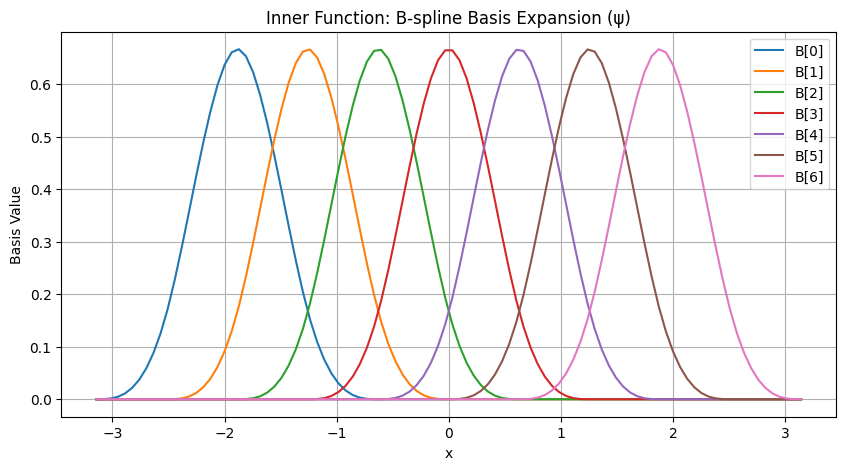

In [59]:
# ===========================================================
# 4. Plot the Inner Function (B-spline Basis)
# ===========================================================
inner_layer = model.hidden_nodes[0]  # Just take one (since all get same x)
B = inner_layer.b_spline(x).detach().numpy()

plt.figure(figsize=(10, 5))
plt.title("Inner Function: B-spline Basis Expansion (ψ)")
for i in range(B.shape[1]):
    plt.plot(x.numpy(), B[:, i], label=f"B[{i}]")
plt.xlabel("x")
plt.ylabel("Basis Value")
plt.legend()
plt.grid()
plt.show()



In [60]:
x

tensor([[-3.1416],
        [-3.0781],
        [-3.0147],
        [-2.9512],
        [-2.8877],
        [-2.8243],
        [-2.7608],
        [-2.6973],
        [-2.6339],
        [-2.5704],
        [-2.5069],
        [-2.4435],
        [-2.3800],
        [-2.3165],
        [-2.2531],
        [-2.1896],
        [-2.1261],
        [-2.0627],
        [-1.9992],
        [-1.9357],
        [-1.8723],
        [-1.8088],
        [-1.7453],
        [-1.6819],
        [-1.6184],
        [-1.5549],
        [-1.4915],
        [-1.4280],
        [-1.3645],
        [-1.3011],
        [-1.2376],
        [-1.1741],
        [-1.1107],
        [-1.0472],
        [-0.9837],
        [-0.9203],
        [-0.8568],
        [-0.7933],
        [-0.7299],
        [-0.6664],
        [-0.6029],
        [-0.5395],
        [-0.4760],
        [-0.4125],
        [-0.3491],
        [-0.2856],
        [-0.2221],
        [-0.1587],
        [-0.0952],
        [-0.0317],
        [ 0.0317],
        [ 0.0952],
        [ 0.

In [61]:
model.hidden_nodes[0](x).detach().numpy()

array([[ 0.0000000e+00],
       [ 2.3454487e-04],
       [ 1.8763590e-03],
       [ 6.3327113e-03],
       [ 1.5010829e-02],
       [ 2.9318042e-02],
       [ 5.0661597e-02],
       [ 8.0448762e-02],
       [ 1.2008681e-01],
       [ 1.7098300e-01],
       [ 2.3454371e-01],
       [ 3.1101143e-01],
       [ 3.9716998e-01],
       [ 4.8916385e-01],
       [ 5.8313704e-01],
       [ 6.7523474e-01],
       [ 7.6160115e-01],
       [ 8.3838052e-01],
       [ 9.0171748e-01],
       [ 9.4775629e-01],
       [ 9.7265095e-01],
       [ 9.7451532e-01],
       [ 9.5583779e-01],
       [ 9.1969806e-01],
       [ 8.6917615e-01],
       [ 8.0735224e-01],
       [ 7.3730624e-01],
       [ 6.6211838e-01],
       [ 5.8486813e-01],
       [ 5.0863570e-01],
       [ 4.3649152e-01],
       [ 3.7074539e-01],
       [ 3.1241965e-01],
       [ 2.6241174e-01],
       [ 2.2161888e-01],
       [ 1.9093841e-01],
       [ 1.7126781e-01],
       [ 1.6350435e-01],
       [ 1.6854537e-01],
       [ 1.8728819e-01],


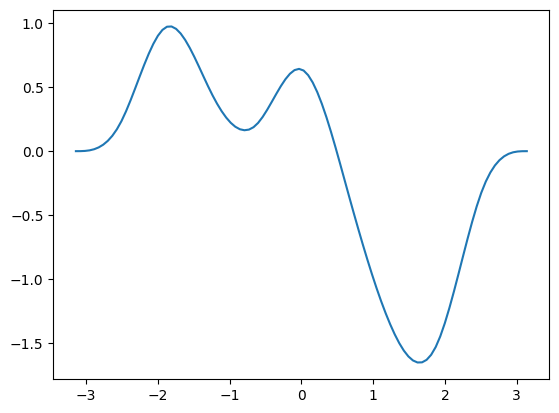

In [62]:
plt.plot(x.numpy(), model.hidden_nodes[0](x).detach().numpy())

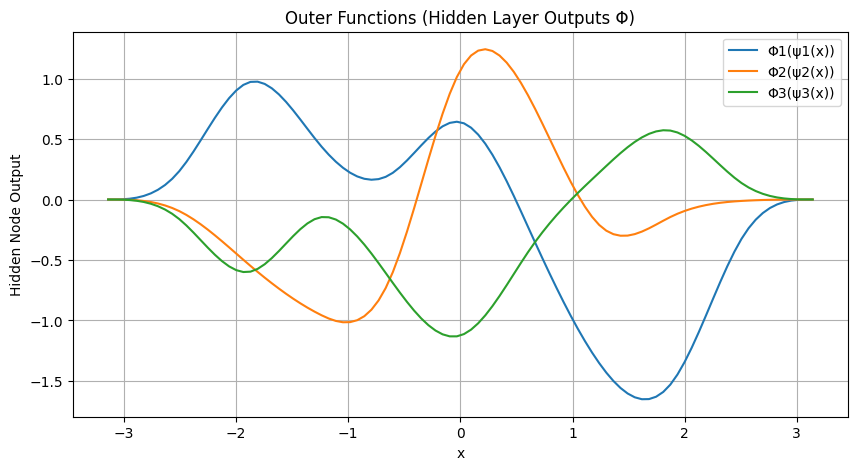

In [63]:

# ===========================================================
# 5. Plot the Outer Functions (Hidden Nodes Φ)
# ===========================================================
plt.figure(figsize=(10, 5))
plt.title("Outer Functions (Hidden Layer Outputs Φ)")
for i, hidden in enumerate(model.hidden_nodes):
    y_hidden = hidden(x).detach().numpy()
    plt.plot(x.numpy(), y_hidden, label=f"Φ{i+1}(ψ{i+1}(x))")
plt.xlabel("x")
plt.ylabel("Hidden Node Output")
plt.legend()
plt.grid()
plt.show()



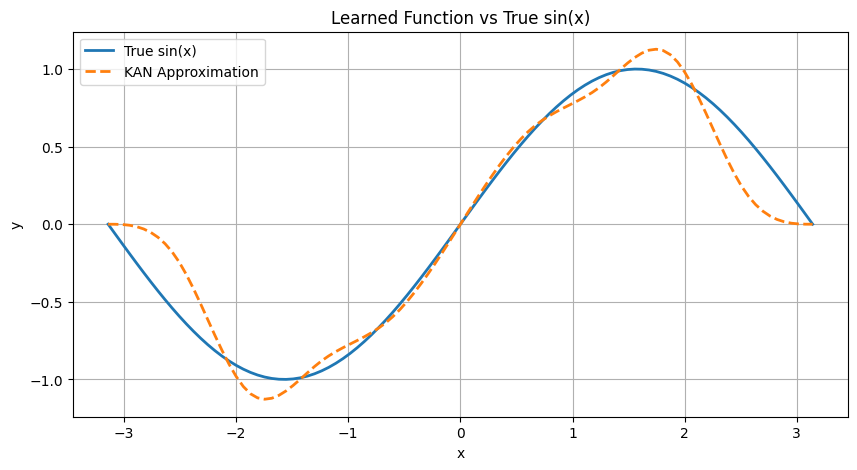

In [64]:

# ===========================================================
# 6. Plot Learned Function vs True sin(x)
# ===========================================================
y_hat = model(x).detach().numpy()

plt.figure(figsize=(10, 5))
plt.title("Learned Function vs True sin(x)")
plt.plot(x.numpy(), y.numpy(), label="True sin(x)", linewidth=2)
plt.plot(x.numpy(), y_hat, label="KAN Approximation",
         linestyle='--', linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()